# Machine Learning Project for Student Depression Data Set

*A student depression dataset typically contains data aimed at analyzing, understanding, and predicting depression levels among students. It may include features such as demographic information (age, gender), academic performance (grades, attendance), lifestyle habits (sleep patterns, exercise, social activities), mental health history, and responses to standardized depression scales. - Data from [Kaggle](https://www.kaggle.com/datasets/hopesb/student-depression-dataset)*

In this notebook, we will create some classifiers. Let's start with this part where we will examine and preprocess the data set.

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
import warnings
warnings.filterwarnings('ignore')

print('All imports were successful!')

All imports were successful!


Create the data set variable.

In [2]:
df = pd.read_csv('/kaggle/input/student-depression-dataset/Student Depression Dataset.csv')
df.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


Let's check info of our <code>df</code> data variable.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

Let's start to <code>data preprocessing</code> part of the project.

## Data Preprocessing

For this part, we will do some changes to use our data set well. This part of the project will be the preparation part of <code>machine learning</code>. Let's start.

<code>id</code> column is not necessary of our project. Let's remove it from our <code>df</code> variable.

In [4]:
df.drop(['id'], axis=1, inplace=True)

So, wonderful! In our data set, we have some columns with categorical data. But for machine learning process, we do not want them. Algorithms we will use require numeric data. So, let's convert our categorical features.

In [5]:
def convert_column_to_numeric(df, col):
    # Create a dict
    unique_values = df[col].unique()
    value_to_number = {value: idx + 1 for idx, value in enumerate(unique_values)}

    # Convert column
    df[col] = df[col].map(value_to_number)

    return df, value_to_number

In [6]:
# Convert categorical data
convert_column_to_numeric(df, 'Gender')
convert_column_to_numeric(df, 'Profession')
convert_column_to_numeric(df, 'Dietary Habits')
convert_column_to_numeric(df, 'Degree')
convert_column_to_numeric(df, 'Have you ever had suicidal thoughts ?')
convert_column_to_numeric(df, 'Family History of Mental Illness')
convert_column_to_numeric(df, 'City')

df.head()

,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,1,33.0,1,1,5.0,0.0,8.97,2.0,0.0,5-6 hours,1,1,1,3.0,1.0,1,1
1,2,24.0,2,1,2.0,0.0,5.90,5.0,0.0,5-6 hours,2,2,2,3.0,2.0,2,0
2,1,31.0,3,1,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,1,3,2,9.0,1.0,2,0
3,2,28.0,4,1,3.0,0.0,5.59,2.0,0.0,7-8 hours,2,4,1,4.0,5.0,2,1
4,2,25.0,5,1,4.0,0.0,8.13,3.0,0.0,5-6 hours,2,5,1,1.0,1.0,1,0


For <code>Sleep Duration</code> column, it is good to convert it as *certain* values.

In [7]:
# Convert from string to float
convert = {
    '5-6 hours': 5.5,
    'Less than 5 hours': 4.5,
    '7-8 hours': 7.8,
    'More than 8 hours': 8.5,
    'Others': 0
}

df['Sleep Duration'] = df['Sleep Duration'].map(convert)
df['Sleep Duration'] = df['Sleep Duration'].astype(float)
df['Sleep Duration'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 27901 entries, 0 to 27900
Series name: Sleep Duration
Non-Null Count  Dtype  
--------------  -----  
27901 non-null  float64
dtypes: float64(1)
memory usage: 218.1 KB


We made our data full with numerical variables so far. Let's control it.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 27901 non-null  int64  
 1   Age                                    27901 non-null  float64
 2   City                                   27901 non-null  int64  
 3   Profession                             27901 non-null  int64  
 4   Academic Pressure                      27901 non-null  float64
 5   Work Pressure                          27901 non-null  float64
 6   CGPA                                   27901 non-null  float64
 7   Study Satisfaction                     27901 non-null  float64
 8   Job Satisfaction                       27901 non-null  float64
 9   Sleep Duration                         27901 non-null  float64
 10  Dietary Habits                         27901 non-null  int64  
 11  De

Our everything is good now. If we do not have any empty cell in our data, we can continue to machine learning part.

In [9]:
df.isna().sum()

Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         3
Family History of Mental Illness         0
Depression                               0
dtype: int64

There are some empty cells... Let's drop them.

In [10]:
df = df.dropna()
df.isna().sum()

Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64

Right now, we have not any empty cell. Let's continue to <code>data visualization</code> part.

## Data Visualization

Here, we will create some visualizations for this project. These visualizations will be about catching depression reasons. Let's start.

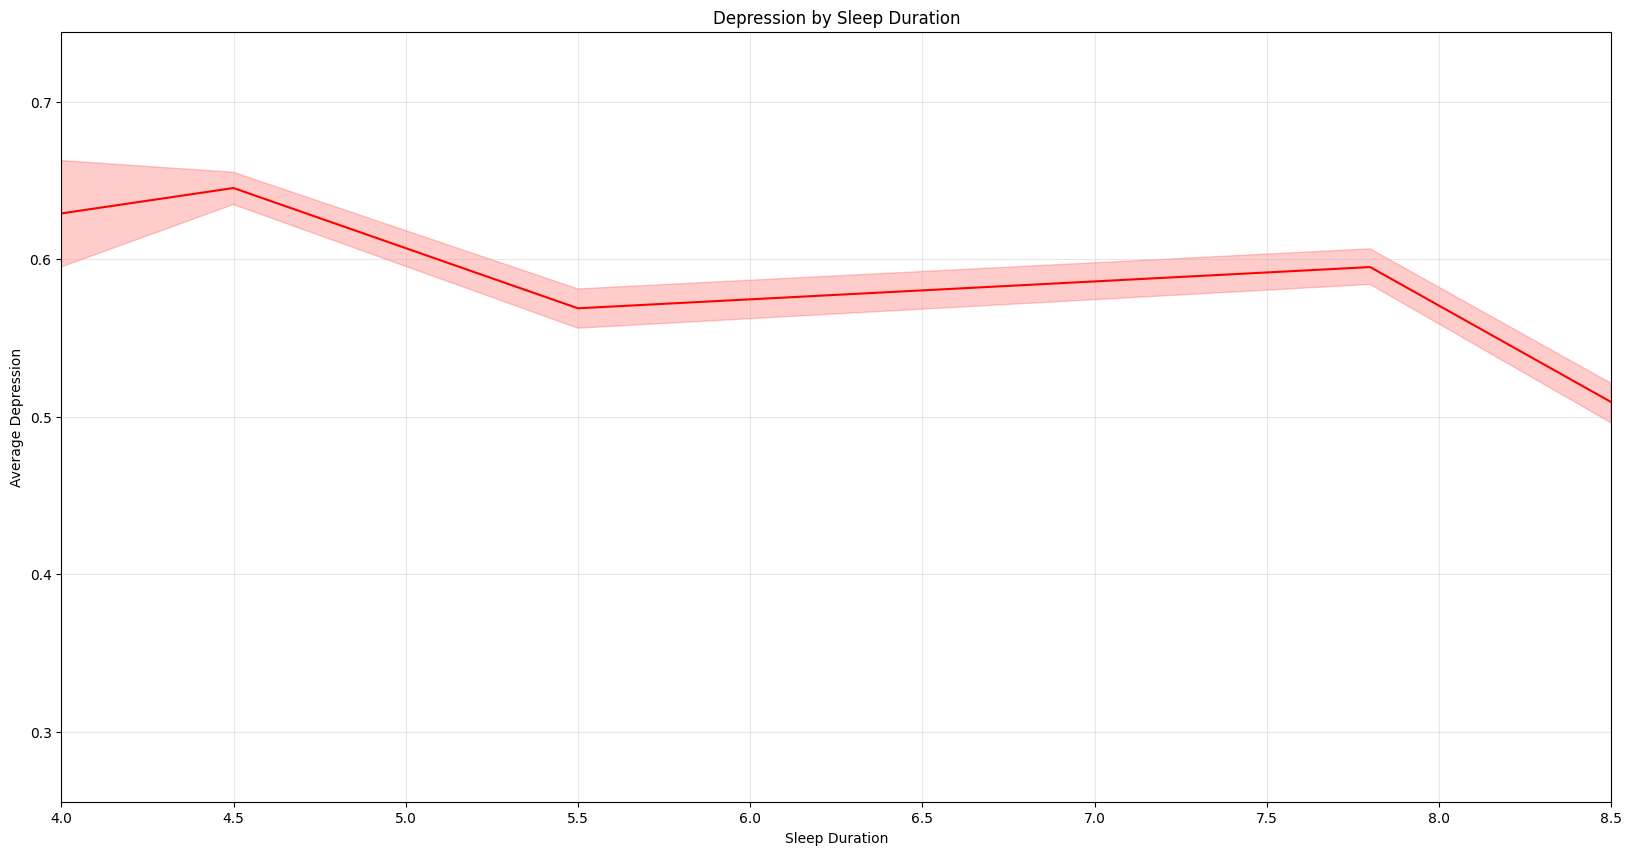

In [11]:
# Create the graph
plt.figure(figsize=(20, 10))
sns.lineplot(data=df, x='Sleep Duration', y='Depression', color='red')

# Adjust the graph
plt.title('Depression by Sleep Duration')
plt.xlabel('Sleep Duration')
plt.ylabel('Average Depression')
plt.xlim(4, 8.5)
plt.grid(alpha=0.3)
plt.show()

The graph above shows that the average of <code>depression</code> from the <code>sleep duration</code> column. It takes depression% rate from the sleep durations.

As you can see from the graph, if you are someone who sleeps more than 7.5 hours, it will be good for you. You have probably less stress from a person who sleeps less.

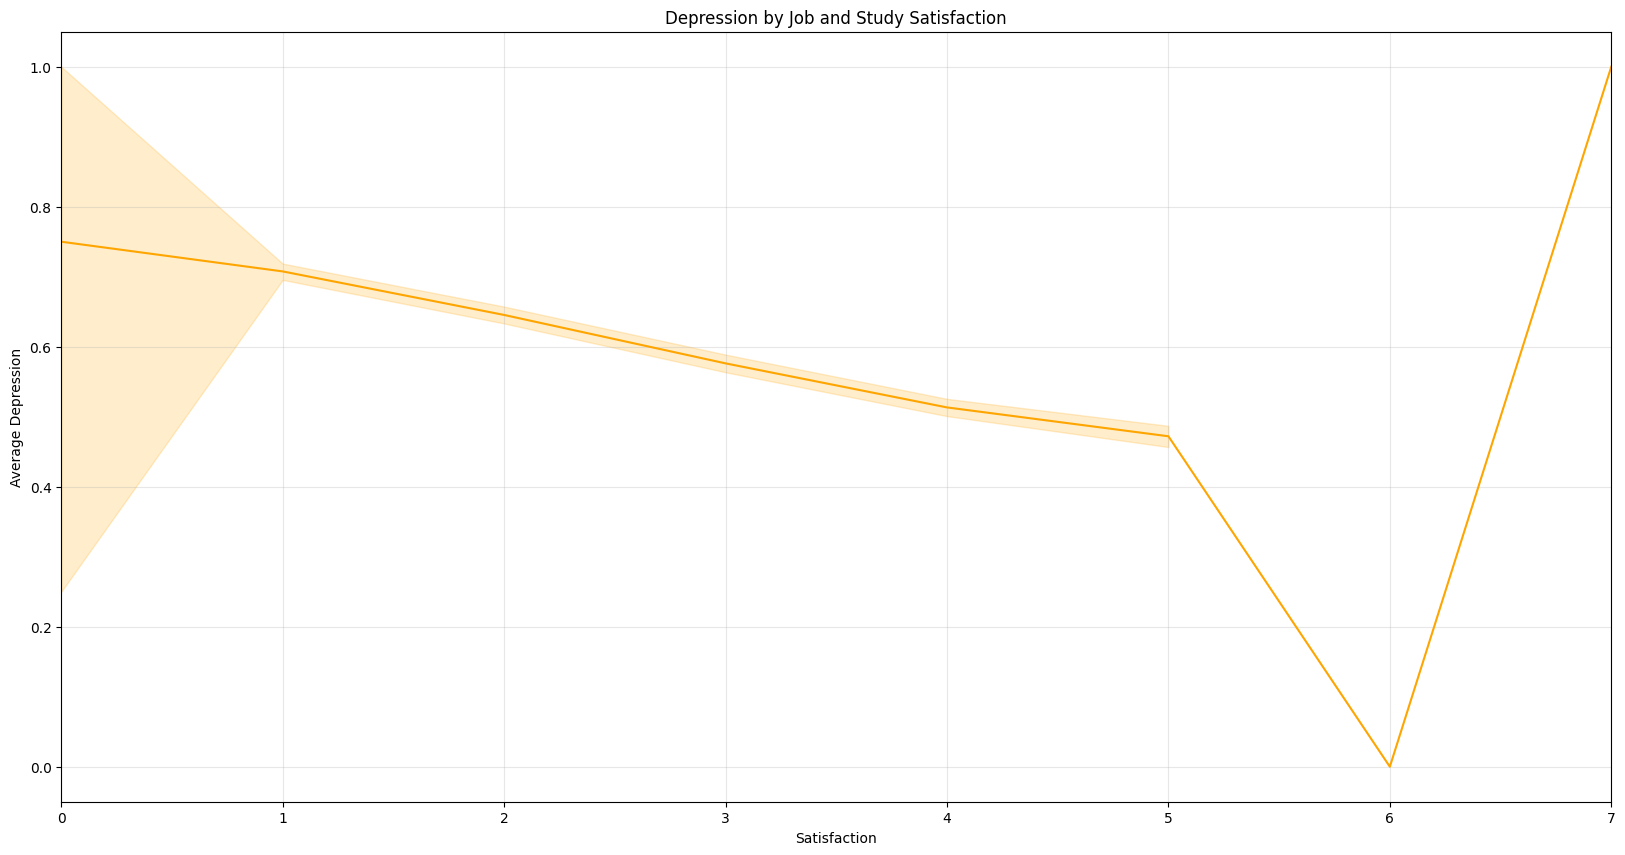

In [12]:
# Create the table variable for the graph
df_satisfaction = pd.DataFrame()
df_satisfaction['Satisfaction'] = df['Study Satisfaction'] + df['Job Satisfaction']
df_satisfaction['Depression'] = df['Depression']

# Create the graph
plt.figure(figsize=(20, 10))
sns.lineplot(data=df_satisfaction, y='Depression', x='Satisfaction', color='orange')

# Adjust the graph
plt.title('Depression by Job and Study Satisfaction')
plt.xlabel('Satisfaction')
plt.ylabel('Average Depression')
plt.xlim(0, 7)
plt.grid(alpha=0.3)
plt.show()

In [13]:
df_satisfaction['Satisfaction'].value_counts()

Satisfaction
4.0    6361
2.0    5840
3.0    5819
1.0    5451
5.0    4421
0.0       4
6.0       1
7.0       1
Name: count, dtype: int64

For this graph, we used job and study satisfaction columns. We added them to each other for using in the graph, because some of them is 0, that can break the graph line. With sum of the these satisfaction levels, you can see the <code>average depression rate</code>.

For level of 6 and 7 for satisfaction column, there are just one examples, so we will not talk about these ones. From the range of 0 to 5 of satisfaction levels, we can say that high satisfaction reduces the depression.

Our next graph is depression rates by age. But before, we need to check how many people from which age range exist in the data.

In [14]:
df['Age'].value_counts()

Age
24.0    2258
20.0    2236
28.0    2133
29.0    1949
33.0    1893
25.0    1784
21.0    1726
23.0    1645
18.0    1587
19.0    1560
34.0    1468
27.0    1462
31.0    1427
32.0    1261
22.0    1160
26.0    1155
30.0    1145
35.0      10
38.0       8
36.0       7
42.0       4
48.0       3
39.0       3
43.0       2
46.0       2
37.0       2
49.0       1
51.0       1
44.0       1
59.0       1
54.0       1
58.0       1
56.0       1
41.0       1
Name: count, dtype: int64

From the information above we can choose the age range of 18 to 38 because there seems to be enough participants in this age range for our chart.

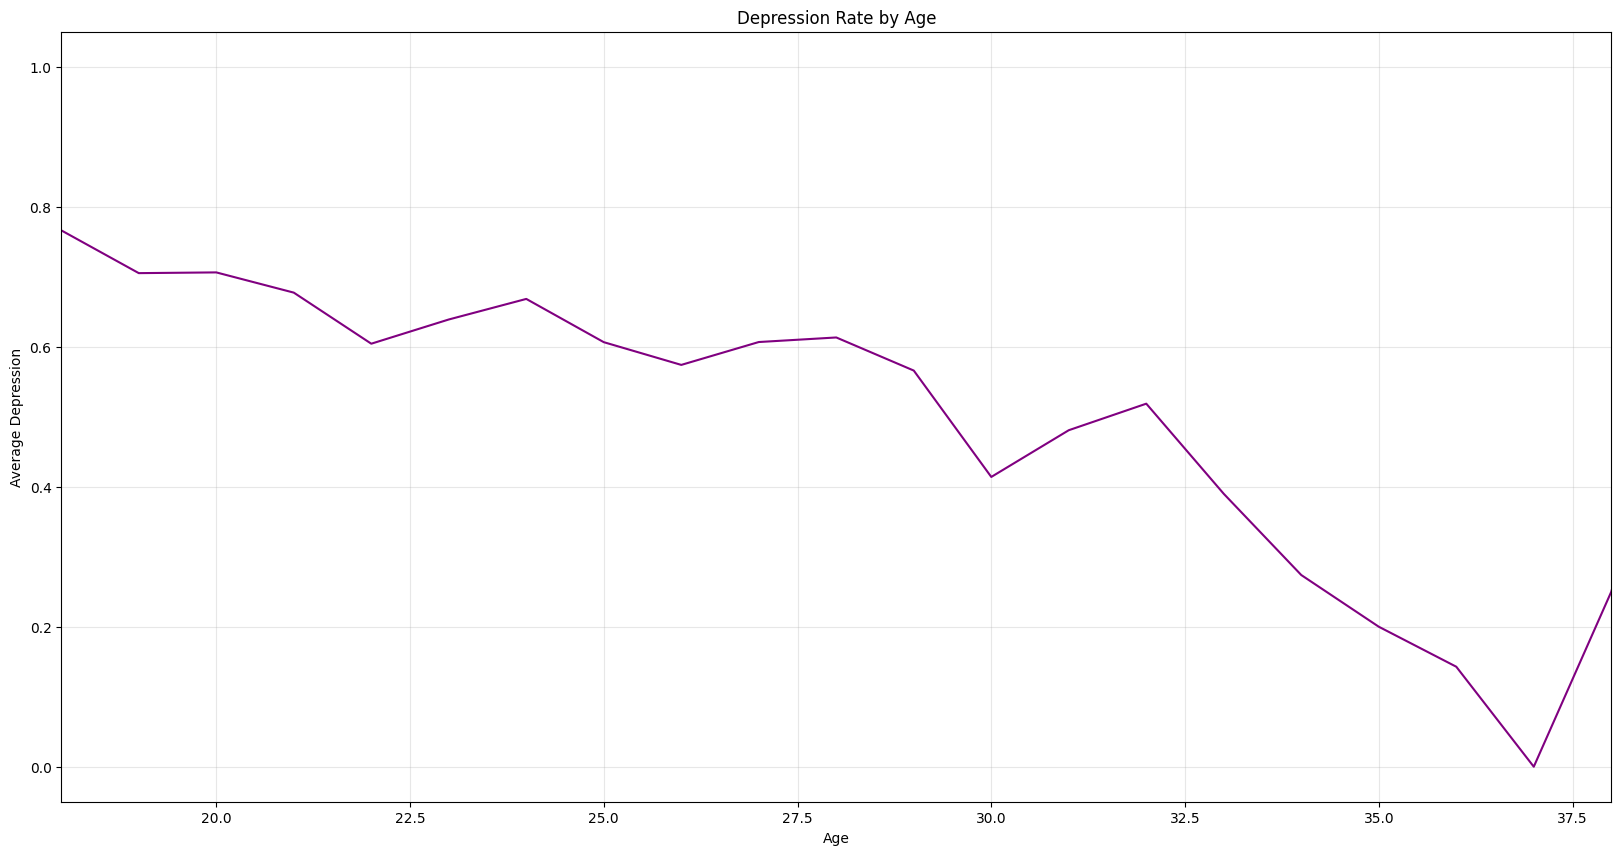

In [15]:
# Create the graph
plt.figure(figsize=(20, 10))
sns.lineplot(data=df, x='Age', y='Depression', color='purple', ci=None)

# Adjust the graph
plt.title('Depression Rate by Age')
plt.xlabel('Age')
plt.ylabel('Average Depression')
plt.grid(alpha=0.3)
plt.xlim(18, 38)
plt.show()

As you can see, lower ages have high average depression rate, while older ages have less. We can say that the reason why young people have a higher stress rate is because of the problems brought by the modern age. Let's continue on our way in this way.

Lastly, let's create a <code>correlation heatmap</code> and see the relationships in the data.

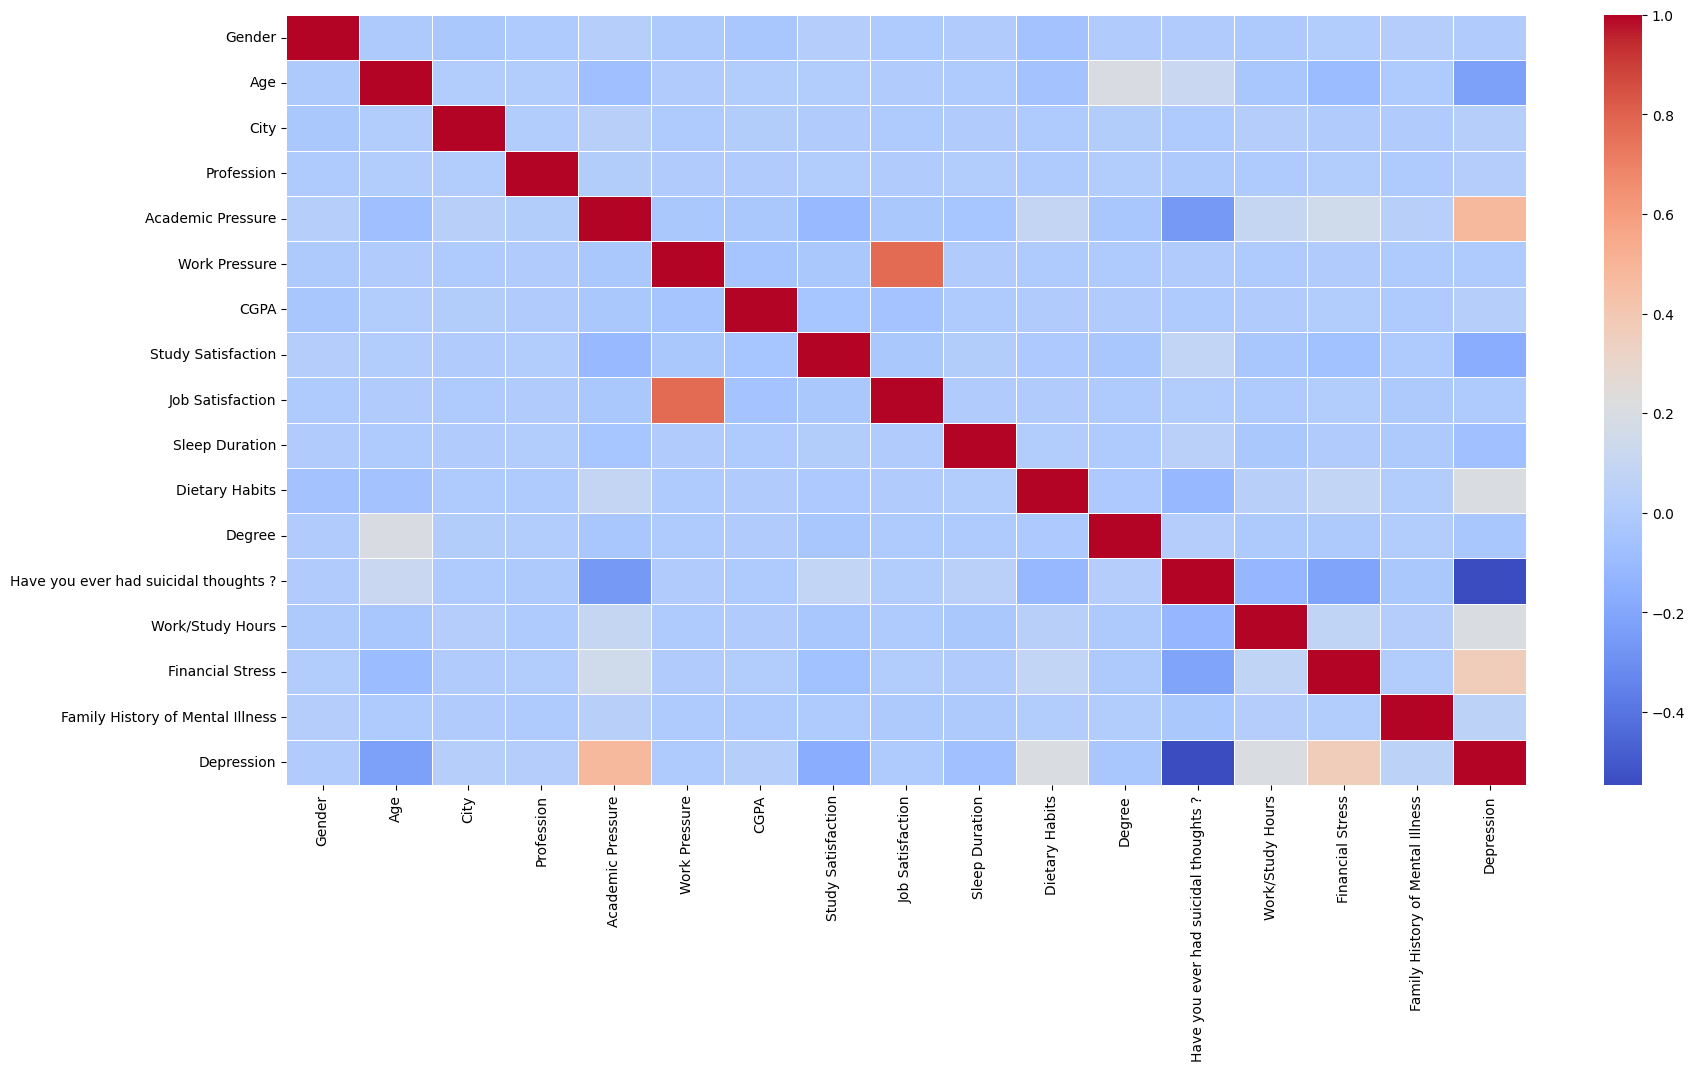

In [16]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False, linewidths=0.5)
plt.show()

From here, you can see that our columns do not have too high correlations with each other. It is a good thing, because you will not have a <code>multicollinearity</code> problem here -this problem may reduce perfomance scores.

That's enough for now. Let's continue to the <code>machine learning</code> part of the project.

## Machine Learning

In this part of the project, we will create some machine learning models that will classify our students if they have depression or not. Our classifiers will be:

* Decision Tree
* Random Forest
* Extra Randomized Trees
* LightGBM
* AdaBoost

For finding the best parameters, we will train <code>GridSearchCV</code>. Let's start with splitting our data

In [17]:
# Split the data
X = df.drop('Depression', axis=1)
y = df['Depression']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

Train <code>Decision Tree Classifier</code>.

In [18]:
# Create parameters
params = {'criterion': ['gini', 'log_loss', 'entropy'],
          'max_depth': [None, 5, 10, 15, 20],
          'min_samples_split': [2, 4, 5, 7, 9],
          'min_samples_leaf': [1, 2, 4, 5, 6]}

# Train a GridSearchCV
grid = GridSearchCV(DecisionTreeClassifier(), params, cv=5).fit(X_train, y_train)

# Train Decision Tree classifier
dtc = DecisionTreeClassifier(**grid.best_params_).fit(X_train, y_train)
y_hat = dtc.predict(X_test)

# Evaluate its performance
dtc_accuracy = accuracy_score(y_test, y_hat)
dtc_recall = recall_score(y_test, y_hat, average='weighted')
dtc_f1 = f1_score(y_test, y_hat, average='weighted')

# Print the performance results
print(f'''Accuracy Score: {dtc_accuracy}
Recall Score: {dtc_recall}
F1 Score: {dtc_f1}''')

Accuracy Score: 0.8245519713261649
Recall Score: 0.8245519713261649
F1 Score: 0.8250522601063395


We will talk about performances later. Let's continue with <code>Random Forest Classifier</code>.

In [19]:
# Train Random Forest Classifier
rfc = RandomForestClassifier(**grid.best_params_).fit(X_train, y_train)
y_hat = rfc.predict(X_test)

# Evaluate its performance
rfc_accuracy = accuracy_score(y_test, y_hat)
rfc_recall = recall_score(y_test, y_hat, average='weighted')
rfc_f1 = f1_score(y_test, y_hat, average='weighted')

# Print the performance results
print(f'''Accuracy Score: {rfc_accuracy}
Recall Score: {rfc_recall}
F1 Score: {rfc_f1}''')

Accuracy Score: 0.8363799283154122
Recall Score: 0.8363799283154122
F1 Score: 0.8351612716715224


Train an <code>Extra Trees Classifier</code>.

In [20]:
# Train an Extra Trees Classifier and make predictions
etc = ExtraTreesClassifier(**grid.best_params_).fit(X_train, y_train)
y_hat = etc.predict(X_test)

# Evaluate the performance
etc_accuracy = accuracy_score(y_test, y_hat)
etc_recall = recall_score(y_test, y_hat, average='weighted')
etc_f1 = f1_score(y_test, y_hat, average='weighted')

# Print the performance results
print(f'''Accuracy Score: {etc_accuracy}
Recall Score: {etc_recall}
F1 Score: {etc_f1}''')

Accuracy Score: 0.8225806451612904
Recall Score: 0.8225806451612904
F1 Score: 0.8204596174337145


Train a <code>LightGBM</code>.

In [21]:
# Create parameters and train a GridSearchCV
params = {
    'num_leaves': [7, 15, 31],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, -1],
    'min_child_samples': [10, 20, 30]
}

grid = GridSearchCV(lgb.LGBMClassifier(verbose=-1), params, cv=5).fit(X_train, y_train)

# Train a LightGBM and make predictions
lgb_model = lgb.LGBMClassifier(**grid.best_params_, verbose=-1).fit(X_train, y_train)
y_hat = lgb_model.predict(X_test)

# Evaluate the performance
lgb_accuracy = accuracy_score(y_test, y_hat)
lgb_recall = recall_score(y_test, y_hat, average='weighted')
lgb_f1 = f1_score(y_test, y_hat, average='weighted')

# Print the performance results
print(f'''Accuracy Score: {lgb_accuracy}
Recall Score: {lgb_recall}
F1 Score: {lgb_f1}''')

Accuracy Score: 0.8492831541218638
Recall Score: 0.8492831541218638
F1 Score: 0.8489052656301938


Train an <code>AdaBoost Classifier</code>.

In [22]:
# Create parameters and train a GridSearchCV
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'algorithm': ['SAMME', 'SAMME.R']
}

grid = GridSearchCV(AdaBoostClassifier(estimator=DecisionTreeClassifier()), params, cv=5).fit(X_train, y_train)

# Train an AdaBoost Classifier and make predictions
abc = AdaBoostClassifier(estimator=DecisionTreeClassifier(), **grid.best_params_).fit(X_train, y_train)
y_hat = abc.predict(X_test)

# Evaluate the performance
abc_accuracy = accuracy_score(y_test, y_hat)
abc_recall = recall_score(y_test, y_hat, average='weighted')
abc_f1 = f1_score(y_test, y_hat, average='weighted')

# Print the performance results
print(f'''Accuracy Score: {abc_accuracy}
Recall Score: {abc_recall}
F1 Score: {abc_f1}''')

Accuracy Score: 0.7718637992831541
Recall Score: 0.7718637992831541
F1 Score: 0.7721511827881137


We created all of our classifiers! For selecting the best model, let's create a graph and see performance evaluation. After that, we can select the best model.

In [23]:
# Create scores dictionary
scores = {'Decision Tree': [dtc_accuracy, dtc_recall, dtc_f1],
          'Extra Randomized Trees': [etc_accuracy, etc_recall, etc_f1],
          'Random Forest': [rfc_accuracy, rfc_recall, rfc_f1],
          'LightGBM': [lgb_accuracy, lgb_recall, lgb_f1],
          'AdaBoost': [abc_accuracy, abc_recall, abc_f1]
}

# Create the data frame and show it
scores_table = pd.DataFrame(scores)
scores_table.index = ['Accuracy', 'Recall', 'F1']
scores_table.head()

,Decision Tree,Extra Randomized Trees,Random Forest,LightGBM,AdaBoost
Accuracy,0.824552,0.822581,0.836380,0.849283,0.771864
Recall,0.824552,0.822581,0.836380,0.849283,0.771864
F1,0.825052,0.820460,0.835161,0.848905,0.772151


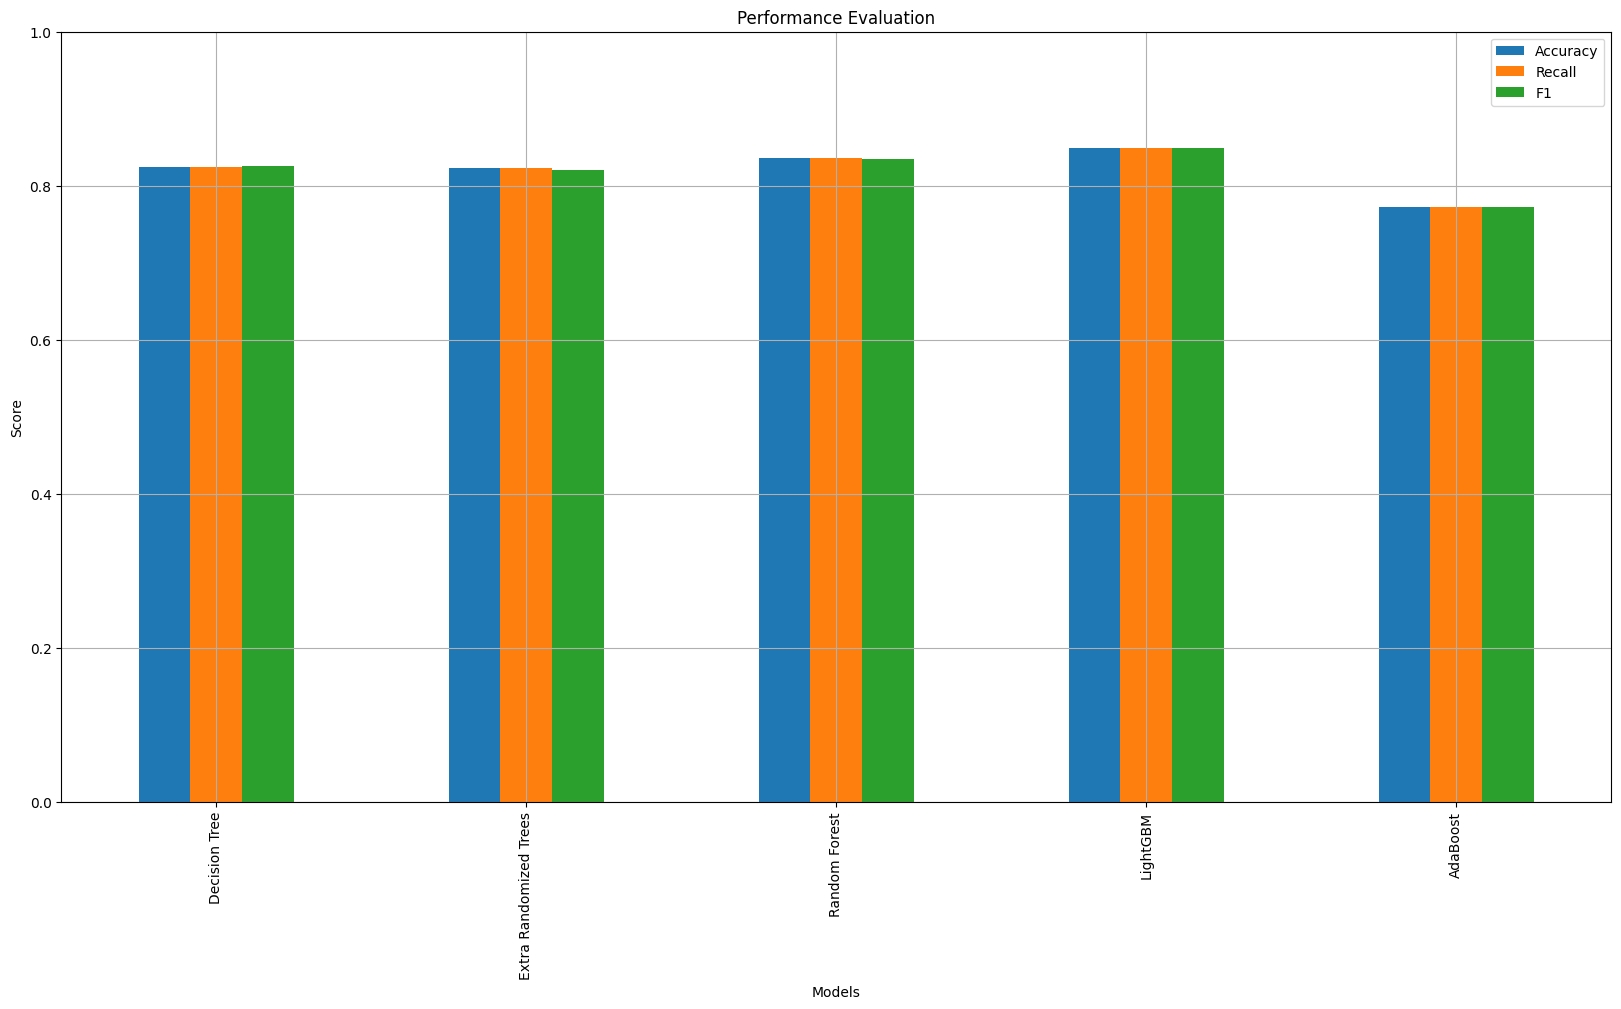

In [24]:
# Create and show the graph
scores_table.T.plot(kind='bar', figsize=(20, 10))
plt.title('Performance Evaluation')
plt.xlabel('Models')
plt.ylabel('Score')
plt.ylim([0, 1])
plt.grid()
plt.show()

From results, you can see that we generally have scores above 80%. Our models are successful generally. But for my case (when I run my notebook), I can see that, the best performance came from <code>LightGBM Classifier</code>. So, we can choose this model for this case. So, this project finishes here. Hope that it will help to the future projects.

Feel free if you want to contribute this project.

### Thank you.

#### Mert Kont (Author of the Project)